In [2]:
import os
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import polars as pl
import seaborn as sns 
import matplotlib.pyplot as plt

client = bigquery.Client(project="sports-analytics-475802")

query = """
SELECT week
    , season
    , home_team
    , away_team
    , play_type
    , yards_gained
    , epa
    , air_epa
    , yac_epa
    , penalty_yards
    , penalty_team
    , penalty_type
    , series_result
    , fixed_drive_result
    , passer
FROM `sports-analytics-475802.nfl_staging.stg_play_by_play`
WHERE season = 2025
"""

result = client.query(query)
data = pl.from_pandas(result.to_dataframe())

data.head()

/Users/matthewdwyer/Documents/nfl_v3/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


week,season,home_team,away_team,play_type,yards_gained,epa,air_epa,yac_epa,penalty_yards,penalty_team,penalty_type,series_result,fixed_drive_result,passer
i64,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,str,str
1,2025,"""PHI""","""DAL""",null,null,0.0,null,null,null,null,null,"""Punt""","""Punt""",null
1,2025,"""WAS""","""NYG""",null,null,null,null,null,null,null,null,"""QB kneel""","""End of half""",null
1,2025,"""NO""","""ARI""",null,null,null,null,null,null,null,null,"""Turnover on downs""","""Turnover on downs""",null
2,2025,"""NYJ""","""BUF""",null,null,null,null,null,null,null,null,"""QB kneel""","""End of half""",null
1,2025,"""SEA""","""SF""",null,null,null,null,null,null,null,null,"""QB kneel""","""End of half""",null


In [3]:
penalty_summary = data.group_by('penalty_team').agg([
    pl.col('penalty_yards').sum().alias('total_penalty_yards')
]).sort('total_penalty_yards', descending=True)

penalty_summary

penalty_team,total_penalty_yards
str,f64
"""DEN""",537.0
"""JAX""",511.0
"""NYG""",506.0
"""DAL""",475.0
"""PHI""",456.0
…,…
"""BAL""",274.0
"""CIN""",254.0
"""PIT""",253.0


/var/folders/p3/klp9g2l57s90c1cfsj8hbd480000gn/T/ipykernel_42238/3357170379.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


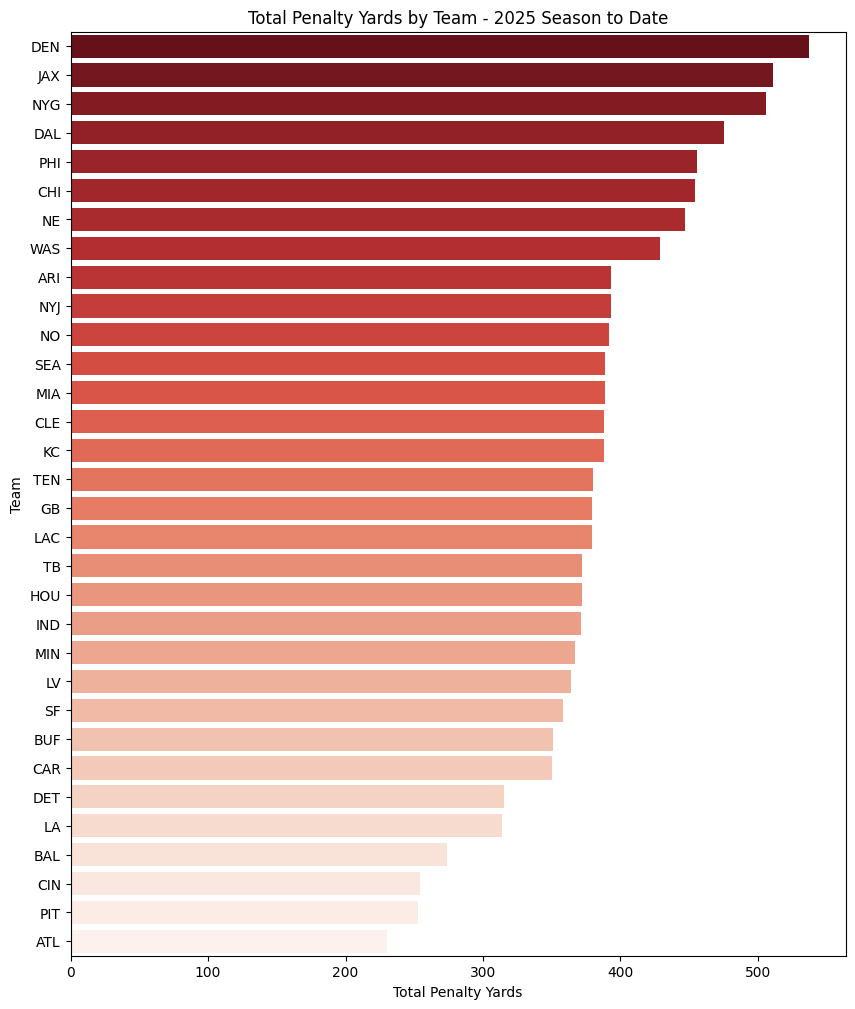

In [4]:
plt.figure(figsize=(10,12))
sns.barplot(
    data=penalty_summary.to_pandas(),
    y='penalty_team',
    x='total_penalty_yards',
    palette='Reds_r'
)
plt.title('Total Penalty Yards by Team - 2025 Season to Date')
plt.xlabel('Total Penalty Yards')
plt.ylabel('Team')
plt.show()

In [8]:
query = """
SELECT * 
FROM `sports-analytics-475802.nfl_analytics.team_game_performance_mart`
WHERE season >= 2024
AND team = 'NYG'
ORDER BY gameday DESC
"""

df = pl.from_arrow(client.query(query).to_arrow())
df.head()

game_id,team,season,week,season_type,gameday,gametime,opponent,home_away,points_scored,points_allowed,result,win,spread_line,total_line,home_moneyline,away_moneyline,roof,surface,temp,wind,stadium,total_yards,passing_yards,rushing_yards,pass_attempts,rush_attempts,completions,completion_percentage,passing_touchdowns,yards_per_attempt,yards_per_completion,rushing_touchdowns,yards_per_carry,first_downs,rushing_first_downs,passing_first_downs,…,kick_return_yards,kick_return_touchdowns,longest_rush,longest_reception,longest_punt,longest_return,offensive_penalty_count,offensive_penalty_yards,yards_allowed,passing_yards_allowed,rushing_yards_allowed,interceptions_forced,fumbles_forced,fumbles_recovered,turnovers_forced,pick_sixes,sacks,sack_yards,tackles_for_loss,solo_tackles,safeties,third_down_attempts_against,third_down_conversions_allowed,third_down_conversion_rate_allowed,fourth_down_attempts_against,fourth_down_conversions_allowed,fourth_down_conversion_rate_allowed,red_zone_plays_faced,red_zone_touchdowns_allowed,red_zone_field_goals_made_allowed,red_zone_field_goals_missed_defense,red_zone_field_goals_blocked_defense,red_zone_td_rate_allowed,defensive_plays,defensive_penalty_count,defensive_penalty_yards,dbt_loaded_at
str,str,i64,i64,str,str,str,str,str,f64,f64,f64,i64,f64,f64,f64,f64,str,str,f64,f64,str,f64,f64,f64,i64,i64,i64,f64,i64,f64,f64,i64,f64,i64,i64,i64,…,f64,i64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,i64,i64,i64,i64,f64,i64,i64,f64,"datetime[μs, UTC]"
"""2025_07_NYG_DEN""","""NYG""",2025,7,"""REG""","""2025-10-19""","""16:05""","""DEN""","""away""",32.0,33.0,1.0,0,7.5,39.5,-425.0,330.0,"""outdoors""","""grass""",72.0,3.0,"""Empower Field at Mile High""",387.0,268.0,119.0,38,32,15,0.394737,3,7.052632,17.866667,2,3.71875,23,7,12,…,85.0,0,31.0,44.0,0.0,30.0,5,22.0,411.0,269.0,142.0,0,0,0,0,0,2,14.0,2,40,0,14,4,0.285714,9,1,0.111111,19,4,0,0,0,0.210526,77,3,14.0,2025-10-21 18:26:36.103564 UTC
"""2025_06_PHI_NYG""","""NYG""",2025,6,"""REG""","""2025-10-09""","""20:15""","""PHI""","""home""",34.0,17.0,17.0,1,-7.0,40.5,310.0,-395.0,"""outdoors""","""fieldturf""",53.0,3.0,"""MetLife Stadium""",368.0,194.0,174.0,28,39,17,0.607143,1,6.928571,11.411765,4,4.461538,24,14,8,…,103.0,0,20.0,35.0,0.0,37.0,4,30.0,339.0,266.0,73.0,1,1,1,2,0,3,17.0,4,33,0,9,1,0.111111,7,2,0.285714,12,2,0,0,0,0.166667,56,2,25.0,2025-10-21 18:26:36.103564 UTC
"""2025_05_NYG_NO""","""NYG""",2025,5,"""REG""","""2025-10-05""","""13:00""","""NO""","""away""",14.0,26.0,12.0,0,1.5,41.5,-120.0,100.0,"""dome""","""sportturf""",null,null,"""Mercedes-Benz Superdome""",335.0,199.0,136.0,41,29,26,0.634146,2,4.853659,7.653846,0,4.689655,23,11,10,…,160.0,0,20.0,18.0,0.0,46.0,5,35.0,333.0,244.0,89.0,0,0,0,0,0,0,0.0,5,39,0,18,7,0.388889,8,1,0.125,8,0,3,0,0,0.0,61,3,60.0,2025-10-21 18:26:36.103564 UTC
"""2025_04_LAC_NYG""","""NYG""",2025,4,"""REG""","""2025-09-28""","""13:00""","""LAC""","""home""",21.0,18.0,3.0,1,-6.0,43.5,230.0,-285.0,"""outdoors""","""fieldturf""",81.0,4.0,"""MetLife Stadium""",252.0,89.0,163.0,27,43,14,0.518519,1,3.296296,6.357143,1,3.790698,20,11,6,…,107.0,0,16.0,18.0,0.0,33.0,3,20.0,340.0,186.0,154.0,2,0,0,2,0,2,17.0,1,36,0,15,4,0.266667,7,0,0.0,2,0,0,0,0,0.0,57,5,23.0,2025-10-21 18:26:36.103564 UTC
"""2025_03_KC_NYG""","""NYG""",2025,3,"""REG""","""2025-09-21""","""20:20""","""KC""","""home""",9.0,22.0,-13.0,0,-6.0,44.5,260.0,-325.0,"""outdoors""","""fieldturf""",65.0,5.0,"""MetLife Stadium""",281.0,151.0,130.0,34,27,18,0.529412,0,4.441176,8.388889,1,4.814815,19,8,7,…,134.0,0,14.0,26.0,0.0,33.0,4,20.0,309.0,201.0,108.0,0,1,0,0,0,2,23.0,1,41,0,17,8,0.470588,6,0,0.0,7,2,1,0,0,0.285714,64,3,62.0,2025-10-21 18:26:36.103564 UTC
